# Konkurs - generowanie obrazów psa
## Autorzy:
#### - Wojciech Rosenthal, INDEX
#### - Grzegorz Pozorski, 180169

In [1]:
import numpy as np
import tensorflow as tf
import cv2
import time
import torch
from PIL import Image
from IPython.display import display

import os
import random

print(tf.__version__)

2.15.0


In [2]:
IMAGE_WIDTH=64
IMAGE_HEIGHT=64
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
dirpath = 'kagglecatsanddogs_5340/PetImages/Dog/'
filenames = [filename for filename in os.listdir(dirpath) if filename.endswith(".jpg")]
print(f"Total number of images: {len(filenames)}")

Total number of images: 12500


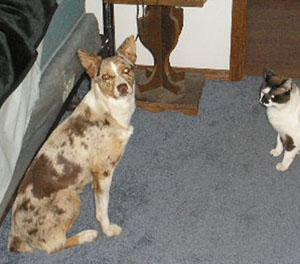

In [38]:
sample = random.choice(dirpath+filenames)
img = Image.open(sample)
display(img)

### Detect objects (dogs) in images and crop them

In [4]:
def make_square(image):
    height, width = image.shape[:2]

    max_side = max(height, width)
    top = bottom = left = right = 0

    if height < max_side:
        diff = max_side - height
        top = diff // 2
        bottom = diff - top
    elif width < max_side:
        diff = max_side - width
        left = diff // 2
        right = diff - left

    mean_color = cv2.mean(image)
    mean_color = tuple(map(int, mean_color))
    padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=mean_color)

    return padded_image

In [5]:
preprocessed_dirpath = 'kagglecatsanddogs_5340/PetImages/Dog-preprocessed/'

if not os.path.exists(preprocessed_dirpath):
    os.makedirs(preprocessed_dirpath)

In [10]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', force_reload=True, trust_repo=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\grzeg/.cache\torch\hub\master.zip
YOLOv5  2024-1-19 Python-3.9.0 torch-2.1.2+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


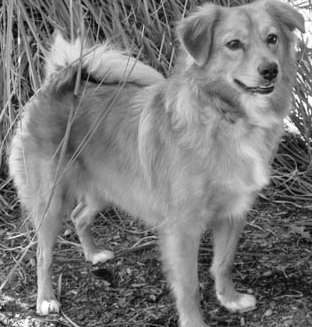

In [63]:
sample = 'kagglecatsanddogs_5340/PetImages/Dog/' + '10003.jpg'
image = cv2.imread(sample, cv2.IMREAD_COLOR)
results = model(image)

pd_results = results.pandas().xyxy[0]
pd_results = pd_results[pd_results['name'] == 'dog']
pd_results = pd_results[pd_results['confidence'] > 0.5]
top, bottom, left, right = pd_results[['ymax', 'ymin', 'xmin', 'xmax']].values[0]
left, right, top, bottom = round(left), round(right), round(top), round(bottom)

image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cropped_image = image[bottom:top, left:right]

img = Image.fromarray(cropped_image)
display(img)

In [74]:
def process_image(filename, dirpath, preprocessed_dirpath):
    try:
        image = cv2.imread(dirpath + filename, cv2.IMREAD_COLOR)
        width, height = image.shape[:2]
        
        results = model(image) 
        
        pd_results = results.pandas().xyxy[0]
        pd_results = pd_results[pd_results['name'] == 'dog']
        pd_results = pd_results[pd_results['confidence'] > 0.5]
        if len(pd_results) == 0:
            return None
        top, bottom, left, right = pd_results[['ymax', 'ymin', 'xmin', 'xmax']].values[0]
        left, right, top, bottom = round(left), round(right), round(top), round(bottom)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        cropped_image = image[bottom:top, left:right]
        
        padded_image = make_square(cropped_image)
        padded_resized_image = cv2.resize(padded_image, IMAGE_SIZE)
        
        cv2.imwrite(preprocessed_dirpath + filename, padded_resized_image)
        
        return width, height
    except Exception as e:
        raise Exception(f"Error processing {filename}: {e}")


In [75]:
mean_size = np.zeros(2)
cnt = 0

start_time = time.time()
for filename in filenames:
    try:
        shape = process_image(filename, dirpath, preprocessed_dirpath)
        if shape:
            mean_size += np.array(shape[:2])
            cnt += 1
    except Exception as e:
        print(f"An error occurred: {e}")

end_time = time.time()
print(f"Total time: {end_time - start_time}")
print(f"Mean size: {mean_size / cnt}.\nTotal count: {cnt}")

### -------------------
# Total time: 1510.6200618743896
# Mean size: [        381       420.6].
# Total count: 6487

An error occurred: Error processing 10158.jpg: 'NoneType' object has no attribute 'shape'
An error occurred: Error processing 10401.jpg: 'NoneType' object has no attribute 'shape'
An error occurred: Error processing 10747.jpg: 'NoneType' object has no attribute 'shape'
An error occurred: Error processing 10797.jpg: 'NoneType' object has no attribute 'shape'
An error occurred: Error processing 11410.jpg: 'NoneType' object has no attribute 'shape'
An error occurred: Error processing 11675.jpg: 'NoneType' object has no attribute 'shape'
An error occurred: Error processing 11702.jpg: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:801: error: (-215:Assertion failed) !buf.empty() in function 'cv::imdecode_'
An error occurred: Error processing 11849.jpg: 'NoneType' object has no attribute 'shape'
An error occurred: Error processing 11853.jpg: 'NoneType' object has no attribute 'shape'
An error occurred: Error processing 1308.jpg: 'NoneType' object has

# VAE

In [6]:
preprocessed_dirpath = 'kagglecatsanddogs_5340/PetImages/Dog-preprocessed/'
filenames = [filename for filename in os.listdir(preprocessed_dirpath)]
print(f"Total number of images: {len(filenames)}")

Total number of images: 6487


In [11]:
X = np.zeros((len(filenames), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.uint8)
for filename in filenames:
    image = cv2.imread(preprocessed_dirpath + filename, cv2.IMREAD_GRAYSCALE)
    X[filenames.index(filename)] = image.reshape(IMAGE_HEIGHT, IMAGE_WIDTH, 1)
    
X_orig = X.copy()

print(X.shape)

(6487, 64, 64, 1)


In [14]:
ratio = 0.8

X = X_orig.copy()

split_index = round(X.shape[0] * ratio)
X_train_val = X[:split_index]
X_test = X[split_index:]

split_index_train_val = round(X_train_val.shape[0] * ratio)
X_train = X_train_val[:split_index_train_val]
X_val = X_train_val[split_index_train_val:]

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (4152, 64, 64, 1)
Validation set shape: (1038, 64, 64, 1)
Test set shape: (1297, 64, 64, 1)


In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.metrics import *

In [16]:
# Please notice - padding="same", so padding is used and no change in spatial resolution is observed
def conv2D_block(input, num_filters, act="gelu", padd="same", k_init="he_normal"):
    conv = Conv2D(num_filters, (3, 3), activation=act, padding=padd, kernel_initializer=k_init)(input)
    conv = Conv2D(num_filters, (3, 3), activation=act, padding=padd, kernel_initializer=k_init)(conv)
    return conv

In [17]:
# Single encoder block
def encoder_block(input, num_filters):
    conv = conv2D_block(input, num_filters)
    pool = MaxPooling2D((2, 2))(conv)
    return conv, pool

In [18]:
# Single decoder block
def decoder_block(input, skip_conn, num_filters):
    uconv = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = concatenate([uconv, skip_conn])
    out = conv2D_block(con, num_filters)
    return out

In [45]:
# Build the model: use encoder block and decoder block
def build_model(input_shape, num_channels=1):
    input_layer = Input(input_shape)

    # Encoder
    c1, p1 = encoder_block(input_layer, 32)
    c2, p2 = encoder_block(p1, 64)  # Additional encoder block

    # Bottleneck
    b1 = conv2D_block(p2, 128)  # output -> (16, 16, 128)

    # Decoder
    d1 = decoder_block(b1, c2, 64)
    d2 = decoder_block(d1, c1, 32)  # Additional decoder block

    # Output
    output_layer = Conv2D(num_channels, (1, 1), padding="same", activation="sigmoid")(d2)

    model = Model(inputs=input_layer, outputs=output_layer, name="ImageAutoencoder")
    return model

In [46]:
# source: https://colab.research.google.com/drive/12kzkT9E-iPCv2zsgTcag8y2Cm9FNDn0_#scrollTo=78wlGjisb2Cg
# BUT extended
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model = build_model(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1))
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[RootMeanSquaredError()])

In [47]:
model.summary()

Model: "ImageAutoencoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d_63 (Conv2D)          (None, 64, 64, 32)           320       ['input_10[0][0]']            
                                                                                                  
 conv2d_64 (Conv2D)          (None, 64, 64, 32)           9248      ['conv2d_63[0][0]']           
                                                                                                  
 max_pooling2d_9 (MaxPoolin  (None, 32, 32, 32)           0         ['conv2d_64[0][0]']           
 g2D)                                                                              

In [48]:
history = model.fit(X_train, X_train, epochs = 20, validation_data = (X_val, X_val))

Epoch 1/20
130/130 [==============================] - 54s 401ms/step - loss: 16223.7500 - root_mean_squared_error: 127.3725 - val_loss: 15980.9023 - val_root_mean_squared_error: 126.4156
Epoch 2/20
130/130 [==============================] - 52s 401ms/step - loss: 16223.7090 - root_mean_squared_error: 127.3723 - val_loss: 15980.9023 - val_root_mean_squared_error: 126.4156
Epoch 3/20
130/130 [==============================] - 51s 393ms/step - loss: 16223.7129 - root_mean_squared_error: 127.3723 - val_loss: 15980.9023 - val_root_mean_squared_error: 126.4156
Epoch 4/20
130/130 [==============================] - 50s 388ms/step - loss: 16223.7090 - root_mean_squared_error: 127.3723 - val_loss: 15980.9023 - val_root_mean_squared_error: 126.4156
Epoch 5/20
130/130 [==============================] - 51s 389ms/step - loss: 16223.7129 - root_mean_squared_error: 127.3723 - val_loss: 15980.9023 - val_root_mean_squared_error: 126.4156
Epoch 6/20
130/130 [==============================] - 51s 390ms/s

In [54]:
import matplotlib.pyplot as plt

def compare_images(image, generated_image):

    fig, ax = plt.subplots(1,2, figsize=(12,6))

    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Image')
    ax[1].imshow(generated_image, cmap='gray')
    ax[1].set_title('Generated image')

    plt.show()

(1297, 64, 64, 1)
1/1 [==============================] - 0s 25ms/step


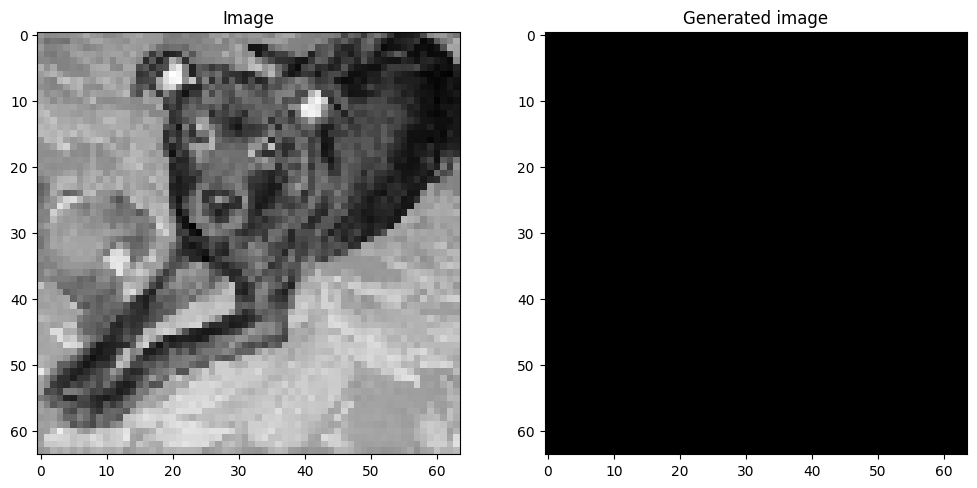

1/1 [==============================] - 0s 23ms/step


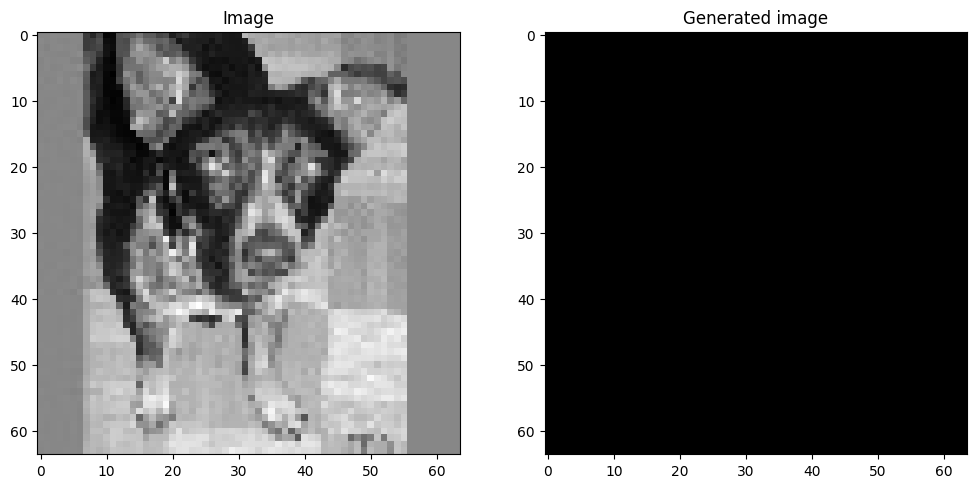

In [56]:
sample_size = 2
print(X_test.shape)
sample = np.random.randint(0, X_test.shape[0], sample_size)
for i in range(sample_size):
    compare_images(X_test[sample[i]], model.predict(np.expand_dims(X_test[sample[i]], 0))[0])

In [ ]:
# TODO:
# - FIX
# - make VAE model
# - save model
# - plot history
# - test model